In [325]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import chi2_contingency

from sklearn.preprocessing import PowerTransformer

# Part 1 - Exploratory Data Analysis

In [326]:
# Load data

login_df = pd.read_json('logins.json')
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [327]:
# Summarize data

login_df.describe()

/tmp/ipykernel_1706357/2290449341.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  login_df.describe()


,login_time
count,93142
unique,92265
top,1970-01-09 01:31:25
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [328]:
# Check if dataframe is ordered

login_df.login_time.is_monotonic_decreasing or login_df.login_time.is_monotonic_increasing

False

In [329]:
# Resample, sort, and count

login = login_df.set_index(keys='login_time').sort_index()
login_series = pd.Series(range(len(login)), index=login.index)
login_series = login_series.resample('15min').count()

# Convert series back to DataFrame
login_df = login_series.to_frame(name='Count')

login_df.head()

,Count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [330]:
# Summary statistics for downsampled data

login_df.describe()

,Count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


Maximum logins in a 15-minute time period were 73, and minimum were 0. On average there are 9 logins every 15 minutes.

## Visualizing data

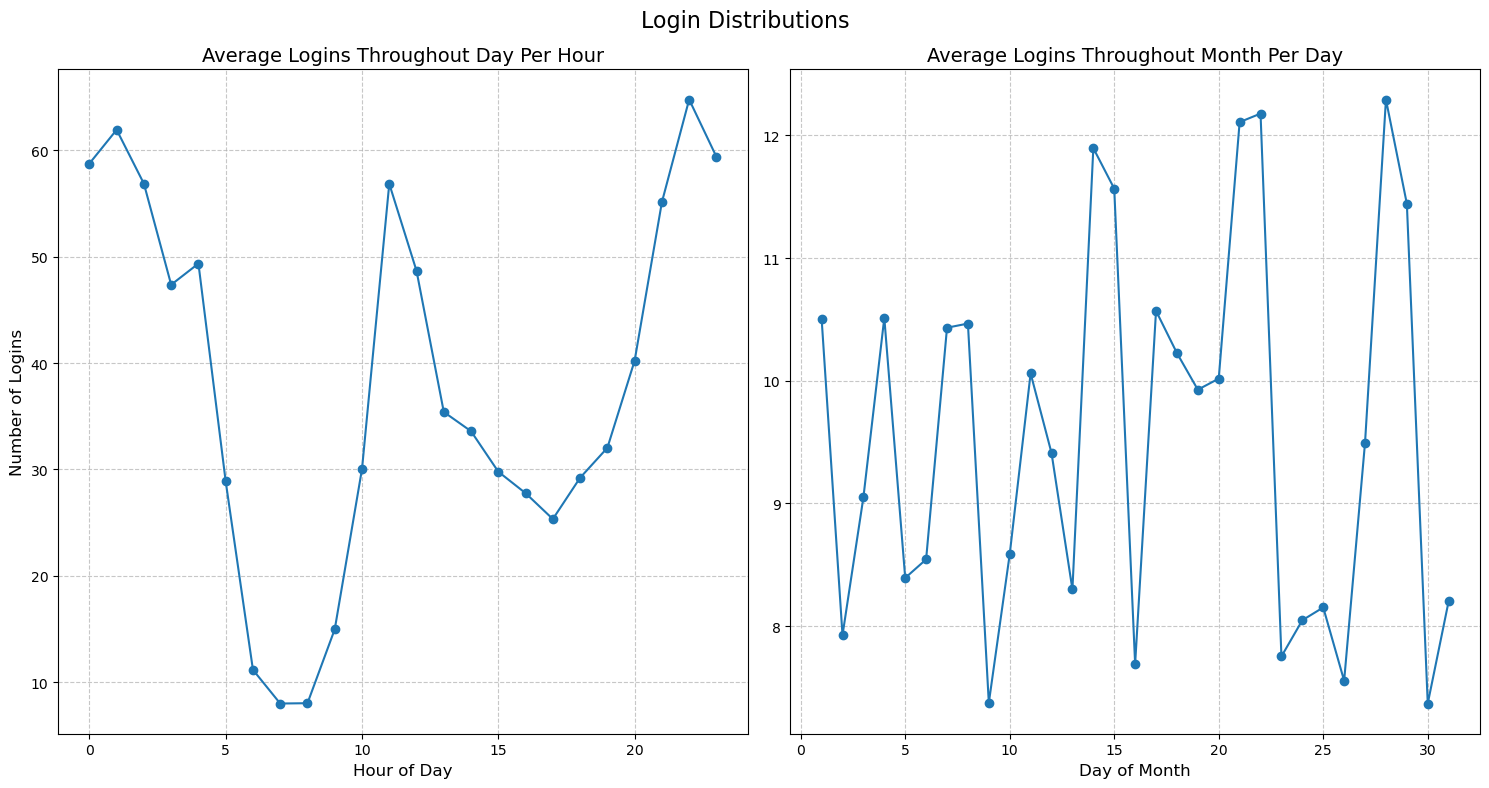

In [331]:
# Visualize logins across months and hours

fig, ax = plt.subplots(1, 2, figsize=(15,8))

# Plot hourly averages throughout day

hourly_login_df = login_df.resample('H').sum()
average_hourly = hourly_login_df.groupby(hourly_login_df.index.hour)['Count'].mean()

ax[0].plot(average_hourly.index, average_hourly.values, marker='o')
ax[0].grid(alpha=0.7, linestyle='--')

ax[0].set_xlabel('Hour of Day', fontsize=12)
ax[0].set_ylabel('Number of Logins', fontsize=12)
ax[0].set_title('Average Logins Throughout Day Per Hour', fontsize=14)

# Plot by day of month

month_grouped = login_df.groupby(login_df.index.day)['Count'].mean()
month_grouped.plot(ax=ax[1], marker='o')
ax[1].grid(alpha=0.7, linestyle='--')

ax[1].set_xlabel('Day of Month', fontsize=12)
ax[1].set_title('Average Logins Throughout Month Per Day', fontsize=14)

fig.suptitle('Login Distributions', fontsize=16)

plt.tight_layout()

plt.show()

When looking at hourly average logins, there does appear to be some seasonality. Particularly, it looks like demand is highly shortly after midnight after which is drops exponentially. It peaks again around noon, experiences a slightly decay, then spikes again close to midnight. This kind of seasonality could correlate with work schedules.

Similarly, there appears to be some form of seasonality when looking at average logins per day of the month. Large peaks happen about every week with a smaller one in the middle of the week.

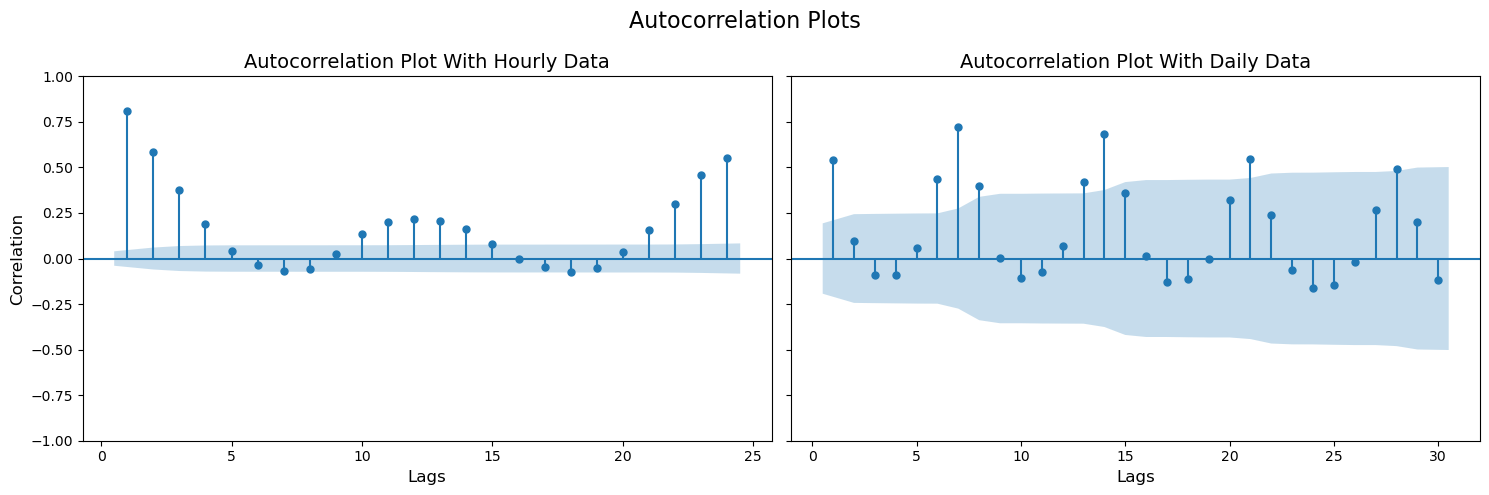

In [332]:
# Plot ACFs for hourly and daily data

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Hourly

plot_acf(x=hourly_login_df, lags=24, zero=False, ax=ax[0])

ax[0].set_xlabel('Lags', fontsize=12)
ax[0].set_ylabel('Correlation', fontsize=12)
ax[0].set_title('Autocorrelation Plot With Hourly Data', fontsize=14)

# Daily

daily_login_df = login_df.resample('D').sum()
plot_acf(x=daily_login_df, lags=30, zero=False, ax=ax[1])

ax[1].set_xlabel('Lags', fontsize=12)
ax[1].set_title('Autocorrelation Plot With Daily Data', fontsize=14)

fig.suptitle('Autocorrelation Plots', fontsize=16)
plt.tight_layout()

plt.show()

These autocorrelation plots confirm our earlier observations regarding the presence of multiple seasonalities in our data.

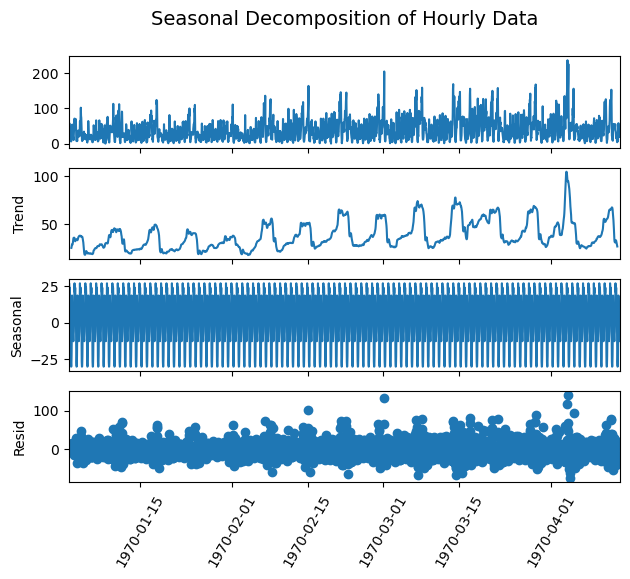

In [333]:
# Hourly decomposition
seasonal_decompose(x=hourly_login_df, period=24).plot()

plt.xticks(rotation=60)
plt.title('Seasonal Decomposition of Hourly Data', fontsize=14, y=4.9)

plt.show()

Although it's difficult to extract fine observations from this decomposition, it further confirms the seasonality we are seeing in hourly data.

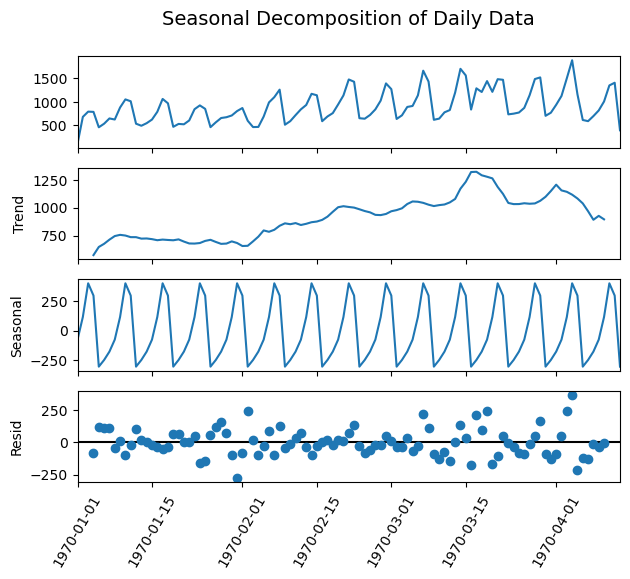

In [334]:
# Daily decomposition

seasonal_decompose(x=daily_login_df, period=7).plot()

plt.xticks(rotation=60)

plt.title('Seasonal Decomposition of Daily Data', fontsize=14, y=4.9)

plt.show()

Although we have some large residuals, this decomposition verifies the weekly seasonality we are seeing. It also confirms an upwards trend up until March, after which the trend seems to be going downwards.

# Part 2 - Experiment and Metrics Design

## 1.)
The focus of the experiment will be to determine whether reimbursing toll costs will encourage driver partners to be available in both cities. In order to measure the success of this experiment, we will measure the amount of time a rider is waiting for a driver. This baseline measurement will be taken before beginning the experiment to confirm driver availability while the toll is in place and will constitute the experiment's control group. Post-experiment measurements of the wait-times in each city will be taken again, constituting the treatment group. By choosing this metric, we'll be able to understand changes in driver availability before and after the experiment, as well as uncover potential patterns in periodicity. 

## 2.)

The design of a practical experiment to solve Ultimate's problem depends on the goals of the company and the time in which they'd like to make changes. One possible problem Ultimate may have in this situation is have enough drivers to cross between Gotham and Metropolis given the toll road. The first step in designing the experiment will be clearly defining our hypotheses:

**Null hypothesis**: The presence of a two-way toll road between Gotham and Metropolis does not affect rider wait time in either city.
**Alternative hypothesis**: Reimbursing all toll costs will encourage driver partners to be available in both cities regardless of city activity, resulting in shorter rider wait times.

To collect adequate data, one calendar year will be spent collecting rider wait times in each city pre and post-experiment. The pre-experiment group will be labelled the control group, while post-experiment will be the treatment group. Data will be collected over the same period of time, ensuring the groups will be comparable. Collecting data over an entire calendar year will also help determine any potential confounding variables affecting driver availability in each city including holidays, school schedules, and sporting events. By matching periods with similar characteristics pre and post experiment, we'll reduce the effects of potential confounders. Additionally, measuring data throughout a calendar year helps account for seasonality, which could influence wait times and driver availability.

In order to verify the statistical significance of our observations, two statistical tests will be used: the ***two-way ANOVA*** test and a ***paired-samples t-Test***. 

The two-way ANOVA test, which estimates how the mean of a quantitative variable changes according to the levels of two categorical variables, will tell us how the presence of the toll and busy times in each city affect rider wait times. The categorical features in this test will be toll presence and city activity. The null hypotheses for this test will be:
1. There is no difference in mean rider wait time with or without a toll.
2. There is no difference in mean rider wait time regardless of the city's activity level.
3. The effect of the toll road does not depend on the effect of the city's activity level.

The t-Test will test whether there is a significant difference in mean rider wait time while the toll road is in effect and when it is not. Since we are investigating the difference within a group between two points in time, we will use the *paired* t-Test.

By using these two tests, we will be able to confirm that the outcomes of the experiment were not due to chance and are statistically significant. This will not imply a solution as simple as reimbursing toll fees throughout the year. A deeper analysis will need to take place which quantifies the financial impact of reimburing toll fees along with any possible financial benefit to having drivers more readily available in both cities at more times. Therefore, although rejecting these null hypotheses will mean that the toll road does have an impact on rider wait time, it does not mean that reimbursing toll fees will necessarily benefit Ultimate. Additionally, there exist other measurable metrics which could provide valuable insight to Ultimate. These include measuring the number of drivers based in each city who travel across the bridge, driver idle time, and ride volume. 

# Part 3 - Predictive Modeling

In [335]:
# Load data

ultimate_df = pd.read_json('ultimate_data_challenge.json', convert_dates=['signup_date', 'last_trip_date'])
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## Cleaning

### Datatypes

In [336]:
# Verify column datatypes

ultimate_df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

We'll go ahead and convert `phone` to categorical type. Otherwise datatypes of features look correct.

In [337]:
# Convert phone to category type

ultimate_df['phone'] = pd.Categorical(values=ultimate_df['phone'], ordered=False)
ultimate_df['phone'].dtypes

CategoricalDtype(categories=['Android', 'iPhone'], ordered=False)

### Range Validation

In [338]:
# Investigate summary statistics for continuous features for any anomalies

ultimate_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


No anomolies stand out. Average rating of driver and rating by driver have some missing values.

### Missing Values

In [339]:
# Percentage of missing alues

ultimate_df.isna().sum() / len(ultimate_df) * 100

city                       0.000
trips_in_first_30_days     0.000
signup_date                0.000
avg_rating_of_driver      16.244
avg_surge                  0.000
last_trip_date             0.000
phone                      0.792
surge_pct                  0.000
ultimate_black_user        0.000
weekday_pct                0.000
avg_dist                   0.000
avg_rating_by_driver       0.402
dtype: float64

Average rating of driver is missing in about 16% of rows. Missing values in phone and average rating by driver are alot fewer, both being less than 1% of rows.

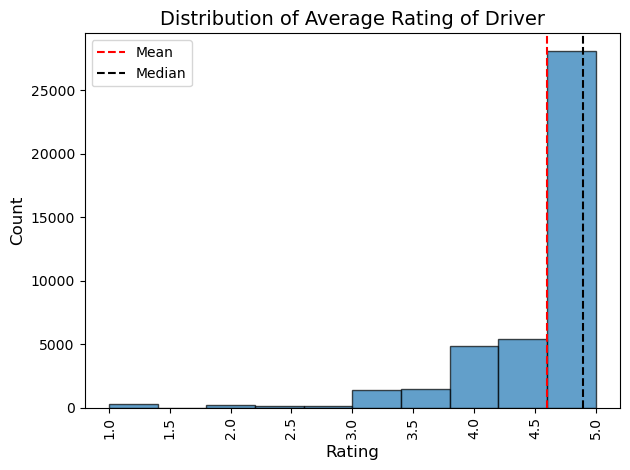

In [340]:
# Visualize distribution of average rating of drivers

fig, ax = plt.subplots()

ax.hist(ultimate_df['avg_rating_of_driver'], alpha=0.7, edgecolor='black')

average_rating_mean = ultimate_df['avg_rating_of_driver'].mean()
average_rating_median = ultimate_df['avg_rating_of_driver'].median()

ax.axvline(x=average_rating_mean, linestyle='--', label='Mean', color='red')
ax.axvline(x=average_rating_median, linestyle='--', label='Median', color='black')

plt.title('Distribution of Average Rating of Driver', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

Based on this distribution, we'll use the *median* to impute missing values in average rating of driver. This is because using the mean would introduce bias towards the lower end of the distribution.

In [341]:
# Fill missing values and confirm result

ultimate_df['avg_rating_of_driver'] = ultimate_df['avg_rating_of_driver'].fillna(value=average_rating_median)
assert ultimate_df['avg_rating_of_driver'].isna().sum() == 0

In [342]:
# Inspect phone column

ultimate_df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

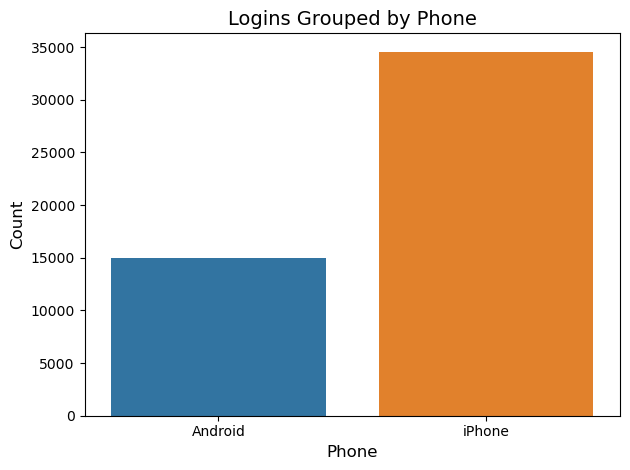

In [343]:
# Visualize distribution of phone

sns.countplot(
    data=ultimate_df,
    x='phone'
)

plt.xlabel('Phone', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Logins Grouped by Phone', fontsize=14)

plt.tight_layout()
plt.show()

Since this is a categorical column, we'll use the *mode* to impute missing values.

In [344]:
# Fill missing values and verify result

phone_mode = ultimate_df['phone'].mode()[0]
ultimate_df['phone'] = ultimate_df['phone'].fillna(value=phone_mode)
assert ultimate_df['phone'].isna().sum() == 0

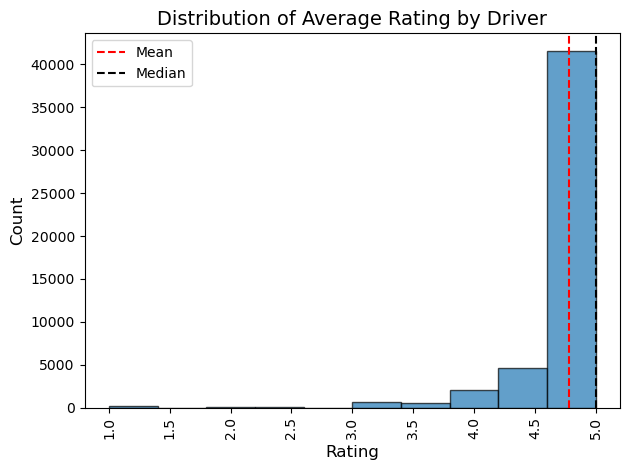

In [345]:
# Visualize distribution of average rating by drivers

fig, ax = plt.subplots()

ax.hist(ultimate_df['avg_rating_by_driver'], alpha=0.7, edgecolor='black')

average_rating_mean = ultimate_df['avg_rating_by_driver'].mean()
average_rating_median = ultimate_df['avg_rating_by_driver'].median()

ax.axvline(x=average_rating_mean, linestyle='--', label='Mean', color='red')
ax.axvline(x=average_rating_median, linestyle='--', label='Median', color='black')

plt.title('Distribution of Average Rating by Driver', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

In order to impute missing values in average rating by drivers, we'll use the median. This is because the distribution of this feature is heavily left-skewed and using the mean the impute the values would result in bias towards small values.

In [346]:
# Fill missing values and verify results

ultimate_df['avg_rating_by_driver'] = ultimate_df['avg_rating_by_driver'].fillna(value=average_rating_median)
assert ultimate_df['avg_rating_by_driver'].isna().sum() == 0

In [347]:
# Verify no more missing values left

assert ultimate_df.isna().sum().all() == 0

## Exploratory Analysis

In [348]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [349]:
# Get sense of time range of trips being investigated

ultimate_df['last_trip_date'].describe()

/tmp/ipykernel_1706357/3324106468.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ultimate_df['last_trip_date'].describe()


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

Based on the range of dates in `last_trip_date`, we'll assume we're looking at the data on July 1st, 2014 and will consider users *active* if they took a trip 30 days prior.

In [350]:
# Create column active to specify whether user took a trip in the past 30 days

reference_date = pd.to_datetime('2014-07-01')
start_date = reference_date - pd.Timedelta(days=30)

ultimate_df['active'] = (ultimate_df['last_trip_date'] >= start_date) & (ultimate_df['last_trip_date'] <= reference_date)
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [351]:
# View class percentages

ultimate_df['active'].value_counts(normalize=True) * 100

False    62.392
True     37.608
Name: active, dtype: float64

About 38% of observed users were retained.

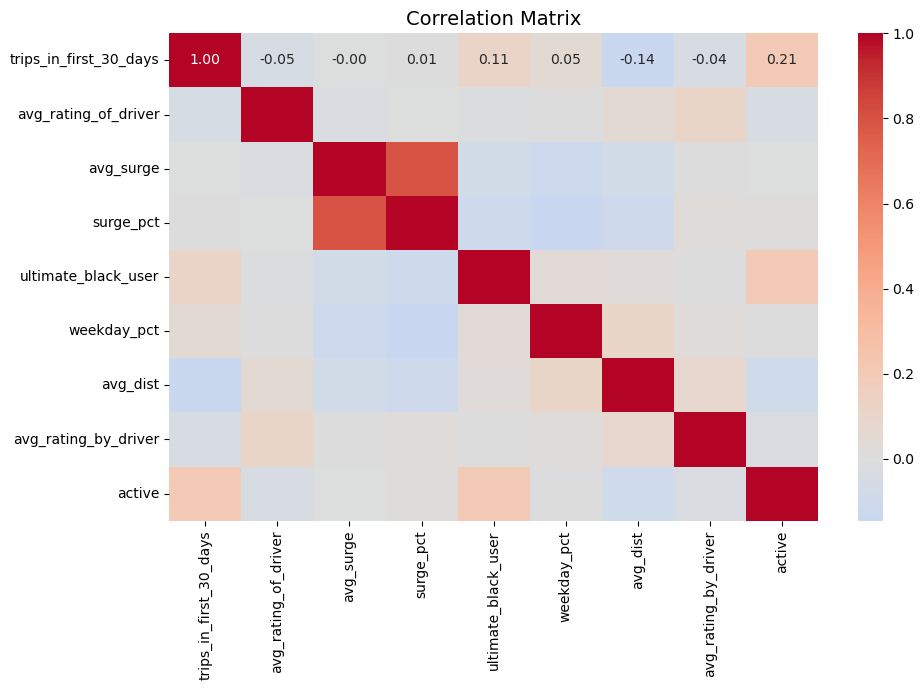

In [352]:
# Generate correlation matrix
correlation_matrix = ultimate_df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10,7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)

plt.title('Correlation Matrix', fontsize=14)

plt.tight_layout()
plt.show()

Looks like `ultimate_black_user` and `trips_in_first_30_days` have some correlation with `active`, while `avg_dist` might have some negative correlation. 

### Relationships between categorical features

In [353]:
# Generate contingency table between ultimate black and phone

ct = pd.crosstab(ultimate_df['phone'], ultimate_df['ultimate_black_user'], rownames=['Phone'], colnames=['Black User'], margins=True, normalize='index')
print(ct)

Black User     False      True
Phone                         
Android     0.679004  0.320996
iPhone      0.598834  0.401166
All         0.622920  0.377080


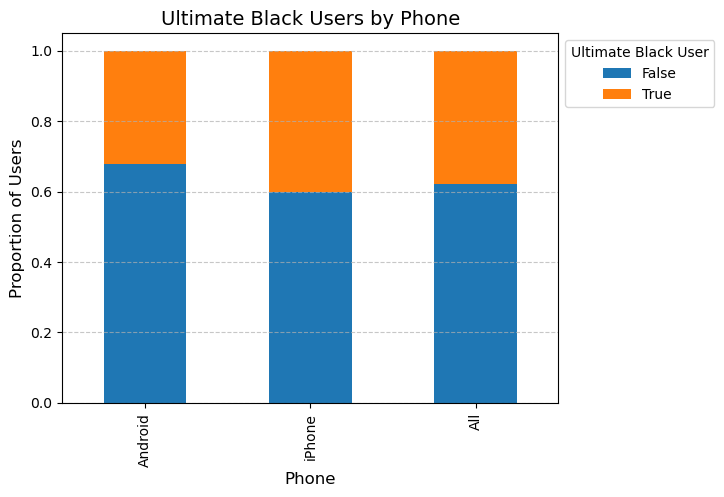

In [354]:
# Plot relationship between ultimate black and phone

ct.plot(kind='bar', stacked=True)
plt.grid(axis='y', alpha=0.7, linestyle='--')

plt.legend(title='Ultimate Black User', bbox_to_anchor=(1, 1))
plt.xlabel('Phone', fontsize=12)
plt.ylabel('Proportion of Users', fontsize=12)
plt.title('Ultimate Black Users by Phone', fontsize=14)

plt.show()

Overall, about 62% of users have not taken an *Ultimate Black* in their first 30 days. There is a slight difference in the proportion of iPhone users and Android users who have taken an Ultimate Black trip in their first 30 days, however, it's not clear if it's statistically significant. A **Chi-squared Test for Independence** will determine if there is significant association between these variables.

**Null hypothesis**: There is no association between phone type and being an ultimate black user.

**Alternative hypothesis**: There is a relationship between phone type and being an ultimate black user.

$\alpha=0.05$

In [355]:
# Perform chi-squared test

ct = pd.crosstab(ultimate_df['phone'], ultimate_df['ultimate_black_user'])
chi2, p, dof, expected = chi2_contingency(ct)

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")

Chi-squared statistic: 287.21115868081813
P-value: 2.0147889559711505e-64


Our very low p-value suggests strongly against our null hypothesis.

In [356]:
# Relationship between city and ultimate black user

ct_black_city = pd.crosstab(ultimate_df['city'], ultimate_df['ultimate_black_user'], normalize='index').iloc[:, ::-1]
ct_black_city

ultimate_black_user,True,False
city,,
Astapor,0.391738,0.608262
King's Landing,0.415202,0.584798
Winterfell,0.350146,0.649854


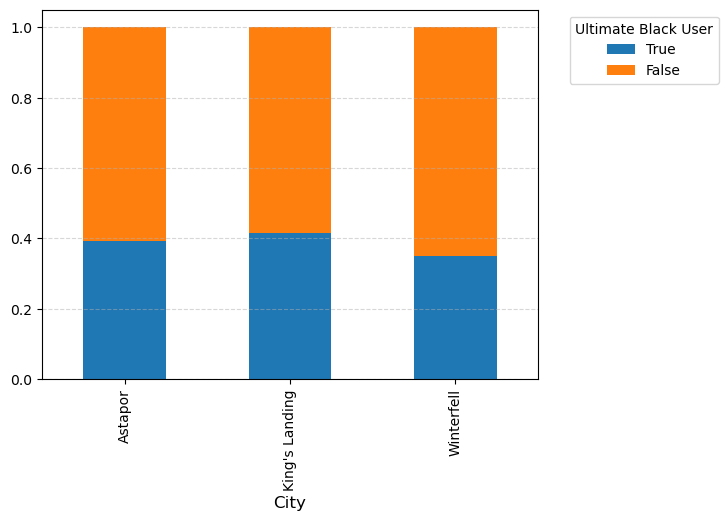

In [357]:
# Visualize distribution of ultimate black users in each city

ct_black_city.plot(kind='bar', stacked=True)
plt.grid(axis='y', alpha=0.5, linestyle='--')

plt.legend(title='Ultimate Black User', bbox_to_anchor=(1.05, 1))
plt.xlabel('City', fontsize=12)

plt.show()

In [358]:
# Conduct chi-squared test of independence between city and ultimate_black_user

chi2, p, dof, expected = chi2_contingency(pd.crosstab(ultimate_df['city'], ultimate_df['ultimate_black_user']))
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")

Chi-squared statistic: 149.87354160257306
P-value: 2.8534741945532337e-33


There is a statistically significant relationship between `city` and `ultimate_black_user`. This is proven by conducting a *chi-squared test of independence* on these two features, yielding a significantly low p-value.

### Relationships between continuous features

#### Average Surge Multiplier

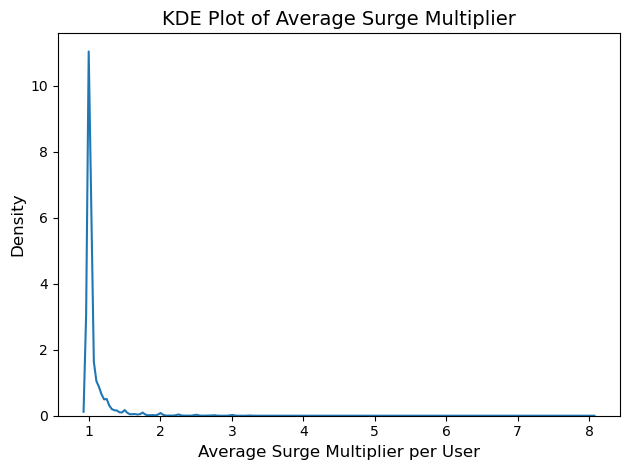

In [359]:
sns.kdeplot(data=ultimate_df, x='avg_surge')

plt.xlabel('Average Surge Multiplier per User', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('KDE Plot of Average Surge Multiplier', fontsize=14)

plt.tight_layout()
plt.show()

Due to the heavily skewed nature of `avg_surge`, we'll see if applying a log transform will improve the distrubution.

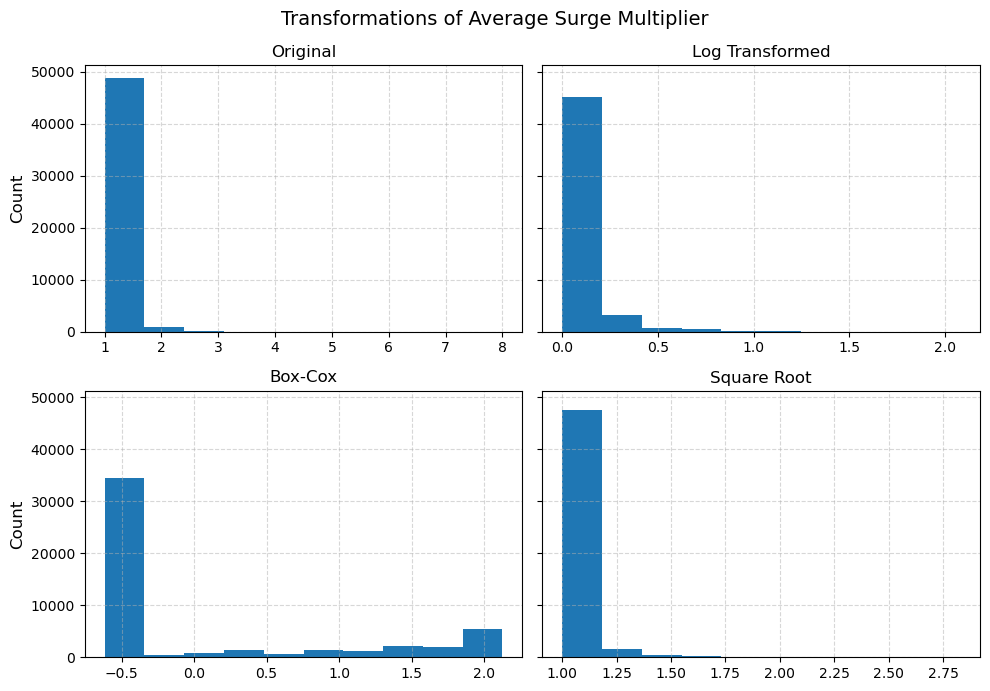

In [360]:
# Log transform average surge
ultimate_df['log_avg_surge'] = np.log(ultimate_df['avg_surge'])

# Apply box-cox transformation
pt = PowerTransformer(method='box-cox')
ultimate_df['transform_avg_surge'] = pt.fit_transform(ultimate_df[['avg_surge']])

# Square root transformation
ultimate_df['sqrt_avg_surge'] = np.sqrt(ultimate_df['avg_surge'])

# Plot data to compare
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(10, 7))

ultimate_df['avg_surge'].hist(ax=ax[0][0])
ultimate_df['log_avg_surge'].hist(ax=ax[0][1])
ultimate_df['transform_avg_surge'].hist(ax=ax[1][0])
ultimate_df['sqrt_avg_surge'].hist(ax=ax[1][1])

ax[0][0].set_ylabel('Count', fontsize=12)
ax[1][0].set_ylabel('Count', fontsize=12)

ax[0][0].set_title('Original')
ax[0][1].set_title('Log Transformed')
ax[1][0].set_title('Box-Cox')
ax[1][1].set_title('Square Root')

fig.suptitle('Transformations of Average Surge Multiplier', fontsize=14)

ax[0][0].grid(alpha=0.5, linestyle='--')
ax[0][1].grid(alpha=0.5, linestyle='--')
ax[1][0].grid(alpha=0.5, linestyle='--')
ax[1][1].grid(alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()

There was no improvement. Let's try applying a box-cox transformation.

This also yielded unsatisfactory results. Using the **inter-quartile range** we'll create a formula for detecting outliers and droppping them.

In [361]:
# Calculate the upper bound based on the iqr

q1 = np.quantile(ultimate_df['avg_surge'], q=0.25)
q3 = np.quantile(ultimate_df['avg_surge'], q=0.75)

iqr = q3 - q1

upper_bound = q3 + (1.5 * iqr)
lower_bound = q1 - (1.5 * iqr)
outlier_avg_surge = ultimate_df[(ultimate_df['avg_surge'] > upper_bound) | (ultimate_df['avg_surge'] < lower_bound)]
outlier_avg_surge.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,log_avg_surge,transform_avg_surge,sqrt_avg_surge
count,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000,8410.000000
mean,2.691320,4.613306,1.394628,42.751724,50.921986,4.305943,4.788098,0.303390,1.918955,1.171633
std,3.749383,0.569647,0.409475,29.090160,34.121182,3.418124,0.367748,0.222348,0.193605,0.148011
min,0.000000,1.000000,1.130000,3.600000,0.000000,0.000000,1.000000,0.122218,1.566861,1.063015
25%,0.000000,4.400000,1.170000,20.500000,25.000000,2.330000,4.700000,0.157004,1.770640,1.081665
50%,2.000000,4.900000,1.250000,33.300000,50.000000,3.300000,4.900000,0.223144,1.976156,1.118034
75%,3.000000,5.000000,1.450000,50.000000,76.875000,5.120000,5.000000,0.371564,2.105028,1.204159
max,49.000000,5.000000,8.000000,100.000000,100.000000,39.490000,5.000000,2.079442,2.126912,2.828427


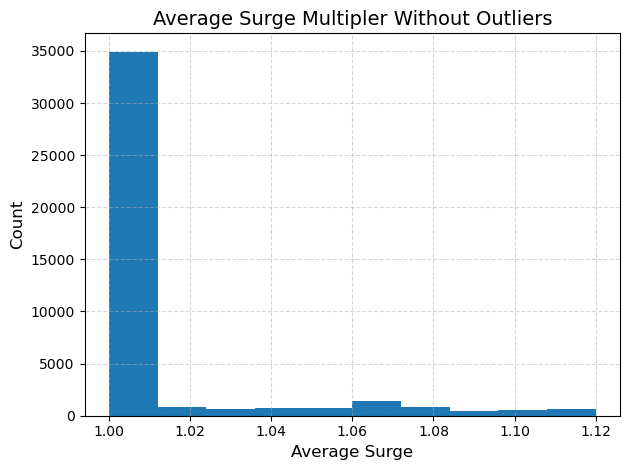

In [362]:
# Plot data after dropping outliers

ultimate_df.drop(outlier_avg_surge.index)['avg_surge'].hist()

plt.grid(linestyle='--', alpha=0.5)
plt.xlabel('Average Surge', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Average Surge Multipler Without Outliers', fontsize=14)

plt.tight_layout()
plt.show()

Dropping outliers did not improve the distribution either. Our heatmap earlier showed high correlation between `avg_surge` and `surge_pct`. If this coefficient is high enough, dropping `avg_surge` from the dataset would accomplish two things:
1. Remove significant outliers from the data
2. Reduces chances of multicollinearity being introduced into model

In [363]:
# Calculate correlation coefficient

print(f"Pearson correlation coefficient: {ultimate_df['avg_surge'].corr(ultimate_df['surge_pct'])}")

Pearson correlation coefficient: 0.7935823335767439


This coefficient is quite high, so we will go ahead and drop `avg_surge` from the dataset.

In [364]:
ultimate_df = ultimate_df.drop(labels=['avg_surge', 'log_avg_surge', 'transform_avg_surge', 'sqrt_avg_surge'], axis=1)
ultimate_df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'last_trip_date', 'phone', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'active'],
      dtype='object')

#### Average ratings

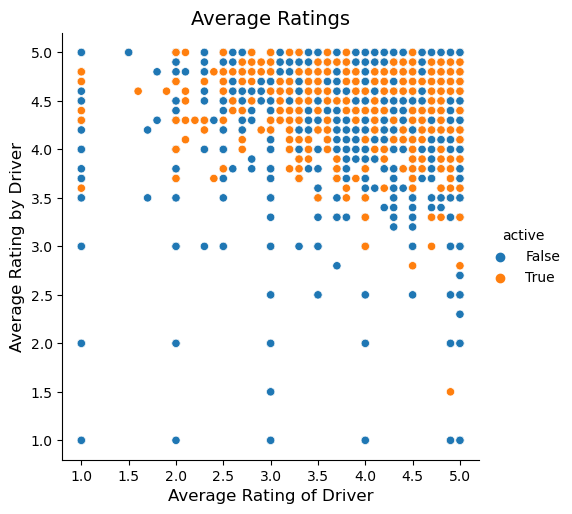

In [365]:
sns.relplot(
    data=ultimate_df,
    x='avg_rating_of_driver',
    y='avg_rating_by_driver',
    hue='active'
)

plt.xlabel('Average Rating of Driver', fontsize=12)
plt.ylabel('Average Rating by Driver', fontsize=12)
plt.title('Average Ratings', fontsize=14)

plt.show()

## Model

In [377]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

RANDOM_STATE = 74

In [367]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [368]:
# Convert categorical columns to dummy variables
dummy_cols = ['city', 'phone']
dummies = pd.get_dummies(ultimate_df[dummy_cols], drop_first=True)
ultimate_df = ultimate_df.drop(dummy_cols, axis=1)
ultimate_df = pd.concat([ultimate_df, dummies], axis=1)

# Convert bool to 0s and 1s
ultimate_df['ultimate_black_user'] = ultimate_df['ultimate_black_user'].astype('int')
ultimate_df['active'] = ultimate_df['active'].astype('int')

# Drop datetime columns
datetime_cols = ['signup_date', 'last_trip_date']
ultimate_df = ultimate_df.drop(datetime_cols, axis=1)

ultimate_df.head()

,trips_in_first_30_days,avg_rating_of_driver,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,15.4,1,46.2,3.67,5.0,1,1,0,1
1,0,5.0,0.0,0,50.0,8.26,5.0,0,0,0,0
2,3,4.3,0.0,0,100.0,0.77,5.0,0,0,0,1
3,9,4.6,20.0,1,80.0,2.36,4.9,1,1,0,1
4,14,4.4,11.8,0,82.4,3.13,4.9,0,0,1,0


In [374]:
# Specify continuous columns for standardizing
continuous_cols = ['trips_in_first_30_days', 'avg_rating_of_driver', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']

# Set up transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols)
    ],
    remainder='passthrough'
)

# Set up cross-validation
kf = KFold(shuffle=True, random_state=RANDOM_STATE)

# Set up test and training data
X = ultimate_df.drop('active', axis=1)
y = ultimate_df['active']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, shuffle=True)

### Logistic Regression

In [370]:
# Define pipeline steps
steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
]

pipeline = Pipeline(steps=steps)

param_grid = {
    'classifier__penalty' : ['elasticnet', 'l2', 'l1'],
    'classifier__C' : np.linspace(0, 4, 10),
    'classifier__solver' : ['lbfgs', 'liblinear', 'saga']
}

# Cross-validation
lr_cv = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, n_jobs=-1)
lr_cv.fit(X_train, y_train)

# Print results
print(f"Mean accuracy score: {round(lr_cv.best_score_, 2)}")
print(f"Best parameters: {lr_cv.best_params_}")

Mean accuracy score: 0.72
Best parameters: {'classifier__C': 0.4444444444444444, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_p

### Random Forest Classifier

In [376]:
# Set up pipeline

steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
]

pipeline = Pipeline(steps)

# Set up hyperparameter tuning parameters

param_grid = {
    'classifier__n_estimators' : np.arange(200,1000),
    'classifier__criterion' : ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth' : np.arange(5,100),
    'classifier__min_samples_split' : np.arange(2,10),
    'classifier__min_samples_leaf' : np.arange(2,10),
    'classifier__min_impurity_decrease' : np.linspace(0, 0.1, 10)
}

# Perform hyperparameter tuning
rf_cv = RandomizedSearchCV(pipeline, param_grid, cv=kf, n_jobs=-1)
rf_cv.fit(X_train, y_train)

# Print results

print(f"Mean accuracy score: {round(rf_cv.best_score_, 2)}")
print(f"Best parameters: {rf_cv.best_params_}")

Mean accuracy score: 0.79
Best parameters: {'classifier__n_estimators': 218, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 7, 'classifier__min_impurity_decrease': 0.0, 'classifier__max_depth': 15, 'classifier__criterion': 'entropy'}


In [378]:
# Set up pipeline

steps = [
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
]

pipeline = Pipeline(steps)

# Set up hyperparameter tuning parameters

param_grid = {
    'classifier__n_estimators' : np.arange(200,1000),
    'classifier__loss' : ['log_loss', 'exponential'],
    'classifier__learning_rate' : np.linspace(0.001, 0.1, 10),
    'classifier__criterion' : ['friedman_mse', 'squared_error'],
    'classifier__min_samples_split' : np.linspace(0.1, 1, 10),
    'classifier__min_impurity_decrease' : np.linspace(0, 0.1, 10)
}

# Perform hyperparameter tuning
gbc_cv = RandomizedSearchCV(pipeline, param_grid, cv=kf, n_jobs=-1)
gbc_cv.fit(X_train, y_train)

# Print results

print(f"Mean accuracy score: {round(gbc_cv.best_score_, 2)}")
print(f"Best parameters: {gbc_cv.best_params_}")

Mean accuracy score: 0.79
Best parameters: {'classifier__n_estimators': 657, 'classifier__min_samples_split': 0.5, 'classifier__min_impurity_decrease': 0.011111111111111112, 'classifier__loss': 'log_loss', 'classifier__learning_rate': 0.045000000000000005, 'classifier__criterion': 'friedman_mse'}


In [379]:
# List best models as determined by hyperparameter tuning

models = {
    'Logistic Regression' : lr_cv.best_estimator_,
    'Random Forest Classifier' : rf_cv.best_estimator_,
    'Gradient Boosting Classifier' : gbc_cv.best_estimator_
}

# Loop through models and score based on test data

model_scores = []

for name, model in models.items():
    print(f"{name} : {model.score(X_test, y_test)}")

Logistic Regression : 0.7193333333333334
Random Forest Classifier : 0.7854666666666666
Gradient Boosting Classifier : 0.7865333333333333


After developing and running these three different predictive models, we'll choose the **Gradient Boosting Classifier** as our definitive model. This is because it performed slightly better than the Random Forest Classifier on the test data as well as on the training data. Even then, the model achieved an accuracy of 79%, meaning it make a correct prediction 79% of the time. This can be adjusted based on Ultimate's desires. For example, if Ultimate is more interested in correctly predicting active users rather than both active and inactive users, we can fine tune our models to improve *precision*. 

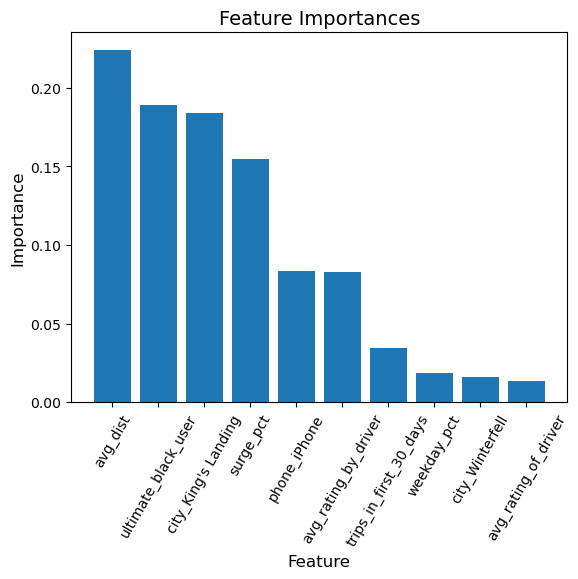

In [385]:
# Extract gradient boosting classifier
classifier = gbc_cv.best_estimator_.named_steps['classifier']

# Extract feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': classifier.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot importances
plt.bar(importance_df['Feature'], importance_df['Importance'])

plt.ylabel('Importance', fontsize=12)
plt.xlabel('Feature', fontsize=12)
plt.title('Feature Importances', fontsize=14)
plt.xticks(rotation=60)

plt.show()

According to the feature importances in our Gradient Boosting Classifier, the top three important features in predicting a users *active* status are the average distance, whether they are an ultimate black user, and if they are from King's Landing.

Based on these insights, Ultimate could decide to either focus their marketing to citizens of King's Landing to further increase their retention, or try to target the other cities to increase the amount of active users in those cities. Knowing that an ultimate black user is more likely to be retained, more emphasis can be placed on influencing users to take an ultimate black ride in their first 30 days. Finally, incentivizing riders to take longer rides could further increase retention.